# KAGGLE: HEART ATTACK PREDICT
AUTHOR: SungwookLE  
DATE: '21.7/4  
DATASET: https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset  

![heart](https://storage.googleapis.com/kaggle-datasets-images/1226038/2046696/2465e7cd117a6954befa50eff39d236f/dataset-cover.jpg?t=2021-03-22-11-33-17)
### About this dataset  
- Age : Age of the patient  
- Sex : Sex of the patient  
- exang: exercise induced angina (1 = yes; 0 = no)  
- ca: number of major vessels (0-3)  
- cp : Chest Pain type chest pain type  
    Value 1: typical angina  
    Value 2: atypical angina  
    Value 3: non-anginal pain  
    Value 4: asymptomatic  
  
- trtbps : resting blood pressure (in mm Hg)
- chol : cholestoral in mg/dl fetched via BMI sensor
- fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- rest_ecg : resting electrocardiographic results
    Value 0: normal  
    Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)  
    Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria  
  
- thalach : maximum heart rate achieved  
- target :  
    0= less chance of heart attack  
    1= more chance of heart attack  
  
  
   
### OVERVIEW
1) Data Analysis
- 데이터 차원, 형태 파악하기
- 그래프 그려서 에측변수 ``와 다른 변수와의 상관관계 파악하기

2) Feature Engineering  
2-1) categorical + numerical features 분리하기
- using `select_dtypes()`.    
- numerical 데이터 중 month나 year 등의 데이터는 categorical로 분류해주기 `apply(str)`  
      
2-2) 비어있는 missing 데이터 채우기  
- numerical: mean, median, mode 를 활용하여 데이터 채우기 `.fillna(xxx)`, `mean(), median(), mode()`
- categorical: `pd.get_dummies()` 나 `LabelEncoder`를 활용해서 missing 데이터도 없애고, one-hot encoding도 완성하기

2-3) data의 skewness 줄이기 
- numerical data 의 skewness 줄이기  

2-4) new feature / del feature
- 필요하다면

3) Modeling
- CrossValidation using `cross_val_score, KFold. train_test_split`.          
- Regressor : `LinearRegression, RidgeCV, LassoCV, ElasticNetCV` 
- Classifier  : `KNN, RandomForest, ...`
- Techniques: `StandardScaler, RobustScaler`.
- Easy modeling: `make_pipeline`

In [1]:
import numpy as np
import pandas as pd
from subprocess import check_output

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
print(check_output(["ls","input"]).decode('utf8'))

heart.csv
o2Saturation.csv



## 1) Data Analysis
데이터 차원, 형태 파악하기  
그래프 그려서 에측변수 output 다른 변수와의 상관관계 파악하기  

In [3]:
heart = pd.read_csv("input/heart.csv")
o2Saturation = pd.read_csv("input/o2Saturation.csv")

In [4]:
heart.shape, o2Saturation.shape

((303, 14), (3585, 1))

output      1.000000
exng        0.436757
cp          0.433798
oldpeak     0.430696
thalachh    0.421741
caa         0.391724
slp         0.345877
thall       0.344029
sex         0.280937
age         0.225439
trtbps      0.144931
restecg     0.137230
chol        0.085239
fbs         0.028046
Name: output, dtype: float64

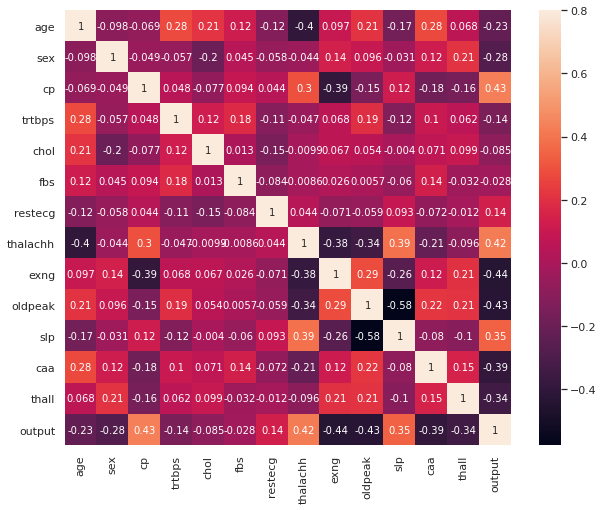

In [5]:
corr = heart.corr()
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr, vmax=0.8, annot=True)
abs(corr['output']).sort_values(ascending=False)

In [6]:
# ALL DATA TYPES are numerical data
heart.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

In [7]:
heart.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [8]:
def facet_plot(feature, range_opt=None):
    facet = sns.FacetGrid(heart, hue='output', aspect=4)
    facet.map(sns.kdeplot, feature, shade = True)

    if not range_opt:
        facet.set(xlim=(0, heart[feature].max()))
    else:
        facet.set(xlim=range_opt)
    facet.add_legend()
    plt.title("Output: "+feature)

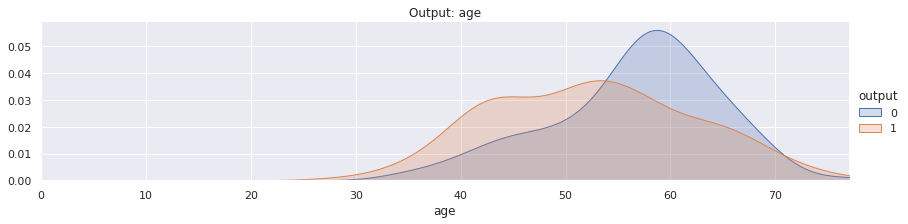

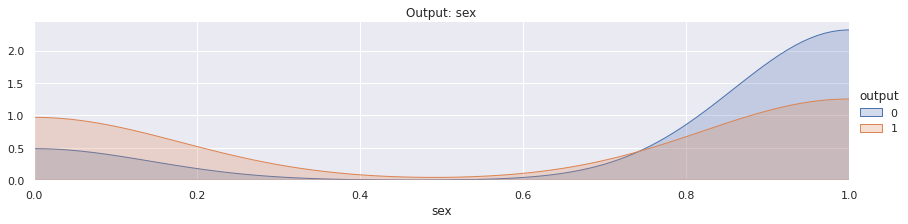

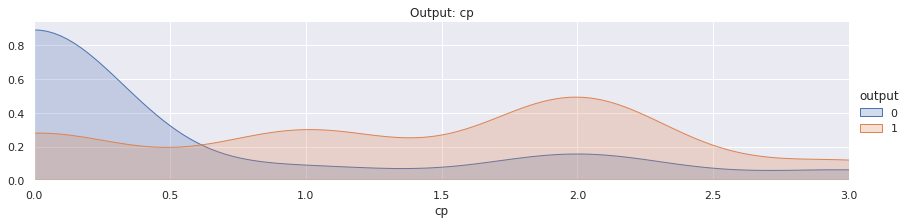

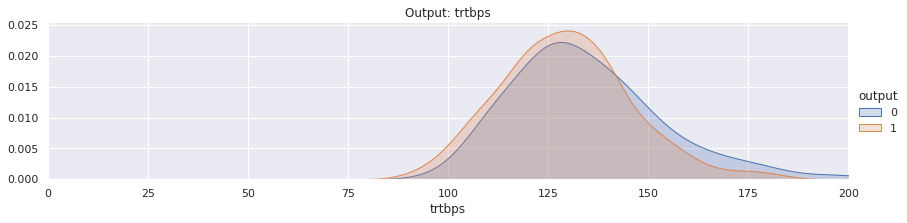

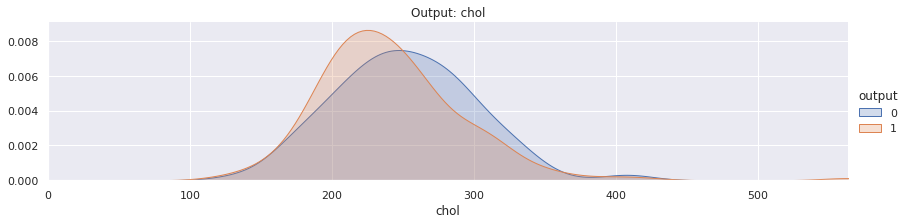

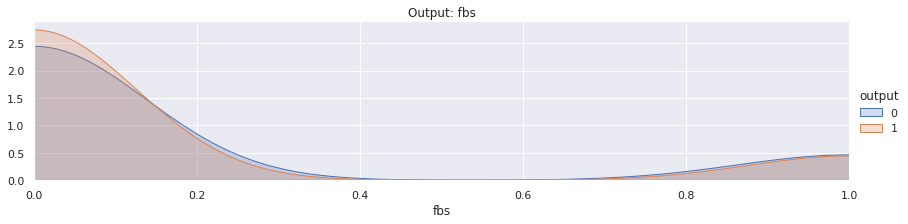

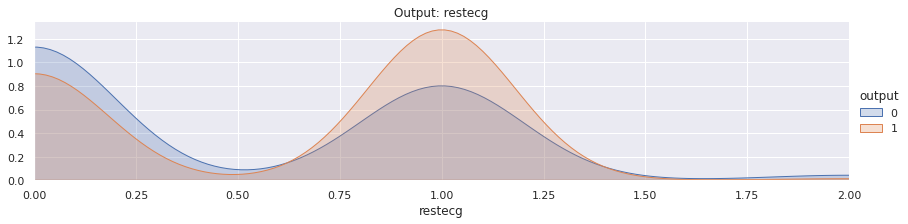

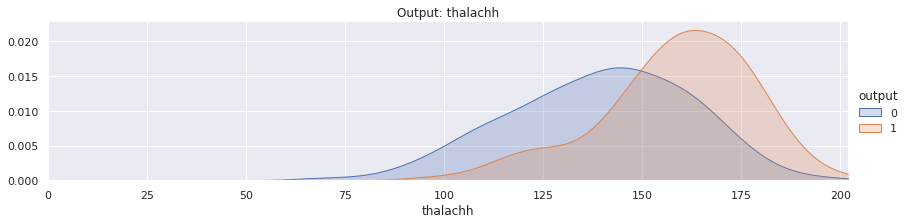

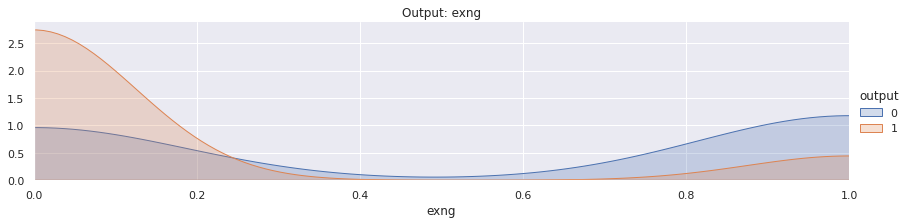

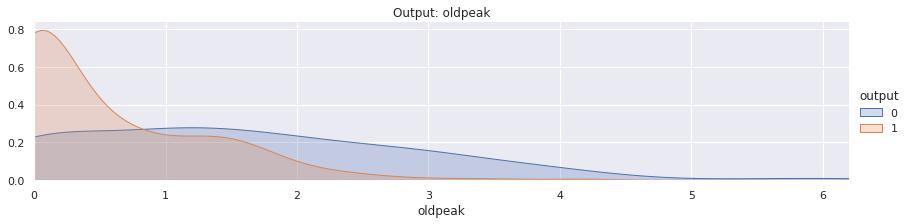

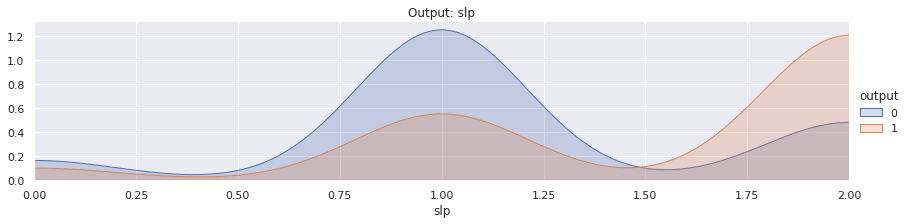

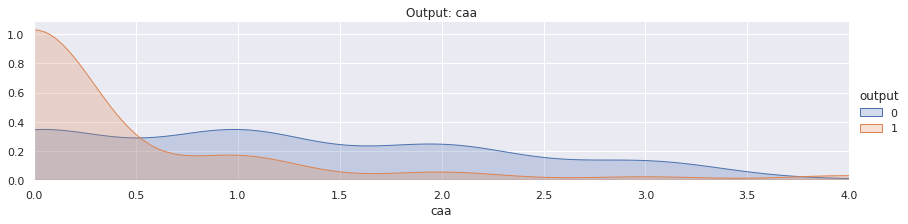

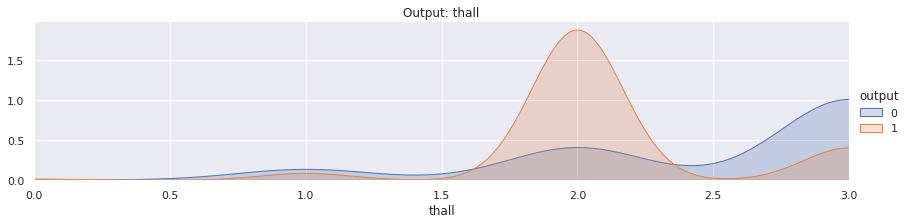

In [9]:
for i in heart.columns:
    if ( i != 'output'):
        facet_plot(i)

In [10]:
heart['cp'].value_counts()

0    143
2     87
1     50
3     23
Name: cp, dtype: int64

## 2) Feature Engineering  
### 2-1) categorical + numerical features 분리하기
- using `select_dtypes()`.    
- numerical 데이터 중 month나 year 등의 데이터는 categorical로 분류해주기 `apply(str)`  

In [11]:
heart['sex']=heart['sex'].apply(str)
# 사실 안해줘도 되는데, 그냥 해준거

In [12]:
heart.dtypes

age           int64
sex          object
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

In [13]:
from sklearn.preprocessing import LabelEncoder

lbl = LabelEncoder()
lbl.fit(heart['sex'])
heart['sex'] =  lbl.transform(heart['sex'].values)

In [14]:
heart['sex'].value_counts()

1    207
0     96
Name: sex, dtype: int64

### 2-2) 비어있는 missing 데이터 채우기
- numerical: mean, median, mode 를 활용하여 데이터 채우기 .fillna(xxx), mean(), median(), mode()
- categorical: pd.get_dummies() 나 LabelEncoder를 활용해서 missing 데이터도 없애고, one-hot encoding도 완성하기

**비어있는 데이터가 없네요,**

### 2-3) data의 skewness 줄이기
- numerical data 의 skewness 줄이기

In [15]:
#비어있는 데이터 없음
heart.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [16]:
from scipy import stats
from scipy.stats import norm, skew # for some statistics

In [17]:
skewness = heart.apply(lambda x: skew(x.dropna()))
skewness = skewness.sort_values(ascending=False)
skewness_features = skewness[abs(skewness.values)>1].index
print("skewness:")
print(skewness_features)

skewness:
Index(['fbs', 'caa', 'oldpeak', 'chol'], dtype='object')


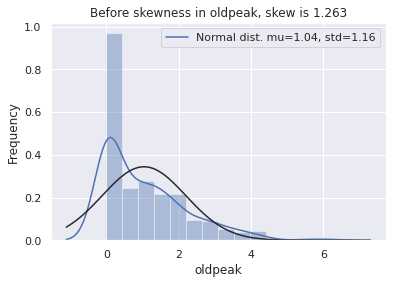

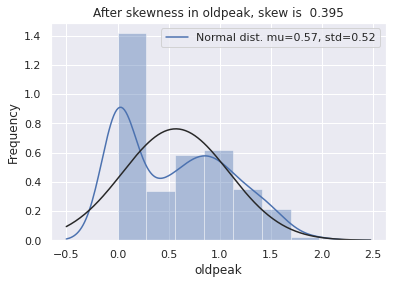

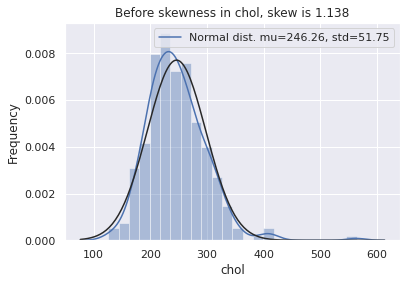

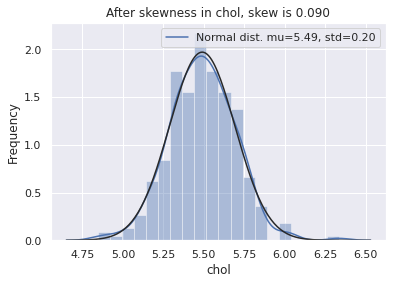

In [18]:
sns.distplot(heart['oldpeak'], fit=norm)
(mu,sigma)=norm.fit(heart['oldpeak'])
plt.legend(['Normal dist. mu={:.2f}, std={:.2f}'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Before skewness in oldpeak, skew is {:.3f}'.format(skewness['oldpeak']))
plt.show()

heart['oldpeak'] = np.log1p(heart['oldpeak'])
sns.distplot(heart['oldpeak'], fit=norm)
(mu,sigma)=norm.fit(heart['oldpeak'])
plt.legend(['Normal dist. mu={:.2f}, std={:.2f}'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('After skewness in oldpeak, skew is  {:.3f}'.format(skew(heart['oldpeak'])))
plt.show()

sns.distplot(heart['chol'], fit=norm)
(mu,sigma)=norm.fit(heart['chol'])
plt.legend(['Normal dist. mu={:.2f}, std={:.2f}'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Before skewness in chol, skew is {:.3f}'.format(skewness['chol']))
plt.show()

heart['chol'] = np.log1p(heart['chol'])
sns.distplot(heart['chol'], fit=norm)
(mu,sigma)=norm.fit(heart['chol'])
plt.legend(['Normal dist. mu={:.2f}, std={:.2f}'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('After skewness in chol, skew is {:.3f}'.format(skew(heart['chol'])))
plt.show()

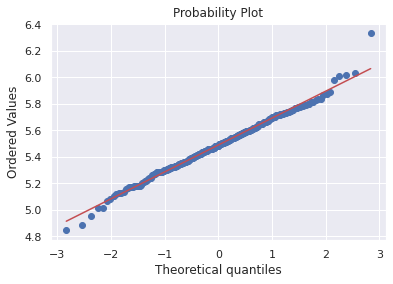

In [19]:
#QQ plots
fig = plt.figure()
res = stats.probplot(heart['chol'], plot=plt)
plt.show()

In [20]:
skewness = heart.apply(lambda x: skew(x.dropna()))
skewness = skewness.sort_values(ascending=False)
skewness_features = skewness[abs(skewness.values)>1].index
print("skewness:")
print(skewness_features)

skewness:
Index(['fbs', 'caa'], dtype='object')


## 3) Modeling
- CrossValidation using `cross_val_score, KFold. train_test_split`.          
- Regressor : `LinearRegression, RidgeCV, LassoCV, ElasticNetCV` 
- Classifier  : `KNN, RandomForest, MLPClassifier...`
- Techniques: `StandardScaler, RobustScaler`.
- Easy modeling: `make_pipeline`

In [21]:
label = heart['output']
heart.drop('output',axis=1, inplace=True)
heart.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,5.455321,1,0,150,0,1.193922,0,0,1
1,37,1,2,130,5.525453,0,1,187,0,1.504077,0,0,2
2,41,0,1,130,5.323010,0,0,172,0,0.875469,2,0,2
3,56,1,1,120,5.468060,0,1,178,0,0.587787,2,0,2
4,57,0,0,120,5.872118,0,1,163,1,0.470004,2,0,2


In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits = 10, shuffle = True, random_state = 0)

In [23]:
RandomForest = make_pipeline(StandardScaler(),RandomForestClassifier(n_estimators=50) )
score = cross_val_score(RandomForest, heart, label, cv= k_fold, n_jobs =1 , scoring='accuracy')
print('RandomForest CrossValidation Score is {:.5f}'.format(np.mean(score)))

RandomForest CrossValidation Score is 0.82215


In [24]:
MLP = make_pipeline(StandardScaler(), MLPClassifier(learning_rate='adaptive'))
score = cross_val_score(MLP, heart, label, cv= k_fold, n_jobs =1 , scoring='accuracy')
print('MLP CrossValidation Score is {:.5f}'.format(np.mean(score)))

MLP CrossValidation Score is 0.84172


- Best Model is SVM as 83.495%

In [25]:
SVM = make_pipeline(StandardScaler(), SVC())
score = cross_val_score(SVM, heart, label, cv= k_fold, n_jobs =1 , scoring='accuracy')
print('SVM CrossValidation Score is {:.5f}'.format(np.mean(score)))

SVM CrossValidation Score is 0.83495


In [26]:
KNN = make_pipeline(StandardScaler(), KNeighborsClassifier())
score = cross_val_score(KNN, heart, label, cv= k_fold, n_jobs =1 , scoring='accuracy')
print('KNN CrossValidation Score is {:.5f}'.format(np.mean(score)))

KNN CrossValidation Score is 0.83194


In [27]:
sts = StandardScaler()
sts.fit(heart)
feed = sts.transform(heart)
feed = pd.DataFrame(feed, columns= heart.columns)

#skewness= feed.apply(lambda x: skew(x.dropna()))
#print(skewness)
#from sklearn.cluster import KMeans
#KMM = KMeans(n_clusters=2)
#KMM.fit(feed)

SVM.fit(feed, label)
pred = SVM.predict(feed)
pred = pd.DataFrame(pred, columns=['output'])

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(feed)

X = pca.transform(feed)
X= pd.DataFrame(X)
X=X.rename(columns={0:'one', 1:'two'})
X = pd.concat([X, pred], axis=1)

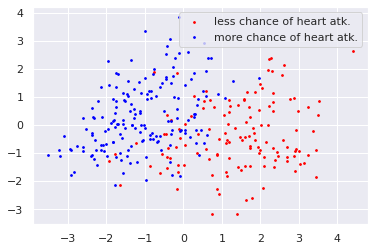

In [28]:
colors = ['red','blue']
labels=[0,1]
legends = ['less chance of heart atk.', 'more chance of heart atk.']

for la, color, leg in zip(labels, colors, legends)W:
    plt.scatter(x=X.loc[X['output']==la]['one'], y = X.loc[X['output']==la]['two'], c =color, s=3, label=leg)
plt.legend()


## 끝
- 데이터 프로세스 & 기계학습 순서를 따라가면, 어느정도의 predict 성능은 나오는데, 83% 정도에서 더 끌어올리기 위해선, **feature engineering**을 신경써서 해주어야 한다.